# Fruit Disease Detection🍎🍇

## Importing necessary libraries📘📙

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from keras.regularizers import L1, L2, L1L2
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.activations import relu, softmax
from keras.models import Sequential
from keras.metrics import Accuracy
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2,os
import joblib

## 🧭 Exploring the data 🧭

In [2]:
example_img_link = '/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust3.JPG'

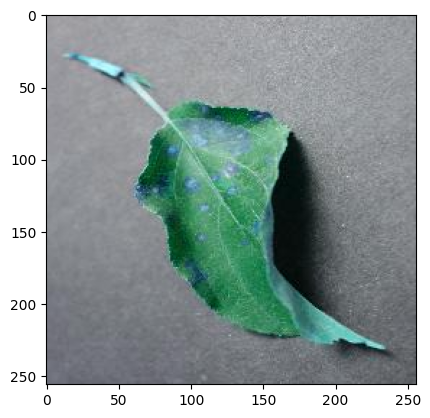

In [3]:
img = cv2.imread(example_img_link)
img = plt.imshow(img)
plt.show()

In [4]:
dir_list = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir_list = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir_list = '/kaggle/input/new-plant-diseases-dataset/test/test'

In [5]:
data = []
for cls in os.listdir(dir_list):
    folder_path = os.path.join(dir_list, cls)
    if os.path.isdir(folder_path):
        img_count = len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg'))])
        data.append({"Class": cls, "Image_Count": img_count})

# Convert to DataFrame
df = pd.DataFrame(data)

# Sort by Image_Count (optional)
df = df.sort_values(by="Image_Count", ascending=False).reset_index(drop=True)
df = df.sort_values(by="Class").reset_index(drop=True)
print(df)


                                                Class  Image_Count
0                                  Apple___Apple_scab         2016
1                                   Apple___Black_rot         1987
2                            Apple___Cedar_apple_rust         1760
3                                     Apple___healthy         2008
4                                 Blueberry___healthy         1816
5            Cherry_(including_sour)___Powdery_mildew         1683
6                   Cherry_(including_sour)___healthy         1826
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...         1642
8                         Corn_(maize)___Common_rust_         1907
9                 Corn_(maize)___Northern_Leaf_Blight         1908
10                             Corn_(maize)___healthy         1859
11                                  Grape___Black_rot         1888
12                       Grape___Esca_(Black_Measles)         1920
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)         

In [6]:
def show_sample_images(dataset_path, prefix="Apple", img_size=175):
    # Get all classes starting with the prefix
    classes = [folder for folder in os.listdir(dataset_path) if folder.startswith(prefix)]
    
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        folder_path = os.path.join(dataset_path, cls)
        sample_img = os.listdir(folder_path)[0]  # Take first image
        img_path = os.path.join(folder_path, sample_img)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))

        plt.subplot(1, len(classes), i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

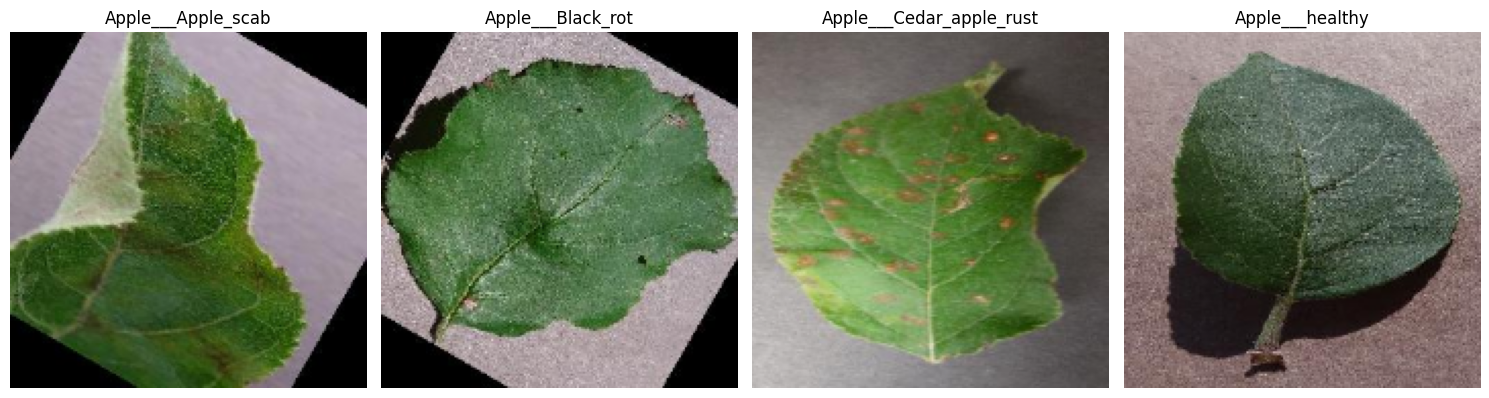

In [7]:
show_sample_images(dir_list, prefix="Apple")

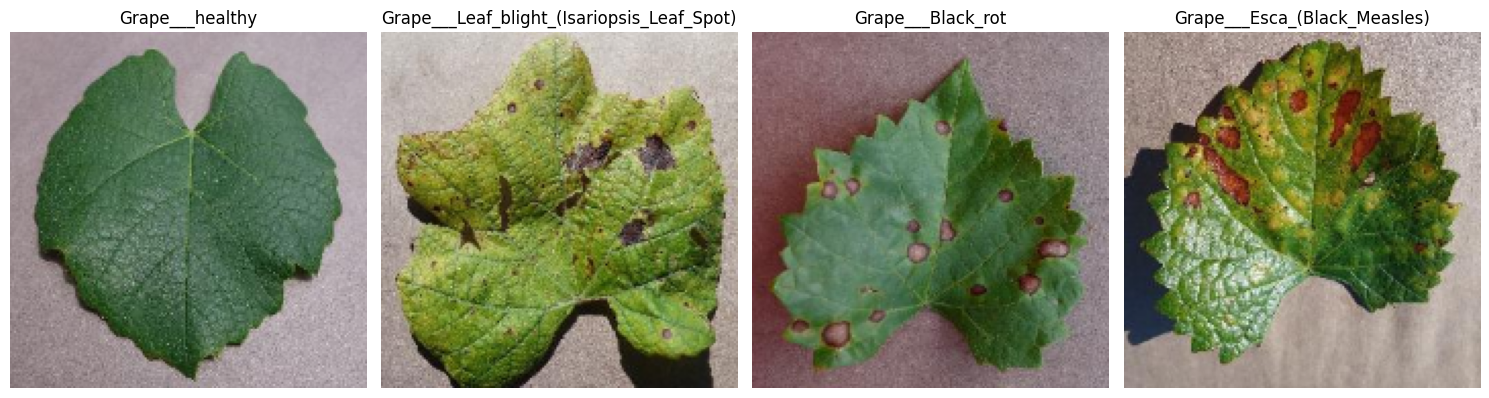

In [8]:
show_sample_images(dir_list, prefix="Grape")

In [9]:
img_size = 175

In [10]:
def read_img(dir_list, encoder, is_transform=False):
    X=[]
    Y=[]
    for folder_name in os.listdir(dir_list):
        folder_path = os.path.join(dir_list, folder_name)
        
    # Only process folders starting with 'tomatodef'
        if not folder_name.startswith(("Apple_", "Grape")):
            continue
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            img = cv2.imread(file_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_size, img_size))
            img = img.reshape(img_size, img_size, 1)
            X.append(img)
            Y.append(folder_name)
    x = np.array(X)
    if is_transform:
        y = encoder.fit_transform(Y)
    else:
        y = encoder.transform(Y)
    return x/255.0,y

In [11]:
encoder = LabelEncoder()

In [12]:
x_train,y_train = read_img(dir_list, encoder, is_transform=True)
x_val,y_val = read_img(val_dir_list, encoder)
x_val,x_test,y_val,y_test = train_test_split(x_val, y_val, test_size=0.3, random_state=42)

In [13]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(14993, 175, 175, 1)
(14993,)
(2623, 175, 175, 1)
(2623,)


In [14]:
label_count = len(encoder.classes_)
print(label_count)

8


## Model trainning with simple CNN architecture

In [15]:
model1 = Sequential([
    Input(shape = (img_size, img_size, 1)),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(label_count, activation='softmax'),
])
model1.summary()

I0000 00:00:1764056755.774203      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 173, 173, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 86, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 84, 84, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,225,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,253,352 (27.67 MB)

 Trainable params: 7,253,352 (27.67 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model1.compile(optimizer='adam', loss=sparse_categorical_crossentropy, metrics=['accuracy'])

In [17]:
History1 = model1.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=100,
    validation_data=(x_val, y_val),
    callbacks = EarlyStopping(patience=3, restore_best_weights=True, verbose=1)
)

Epoch 1/20


I0000 00:00:1764056763.128971     115 service.cc:148] XLA service 0x789ebc00dbd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764056763.129797     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764056763.420515     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/150 ━━━━━━━━━━━━━━━━━━━━ 16:57 7s/step - accuracy: 0.1500 - loss: 2.0804

I0000 00:00:1764056768.376664     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.3639 - loss: 1.6538 - val_accuracy: 0.7510 - val_loss: 0.6736
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7439 - loss: 0.6877 - val_accuracy: 0.8372 - val_loss: 0.4618
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8416 - loss: 0.4448 - val_accuracy: 0.8486 - val_loss: 0.4013
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8827 - loss: 0.3219 - val_accuracy: 0.8757 - val_loss: 0.3353
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9249 - loss: 0.2144 - val_accuracy: 0.8814 - val_loss: 0.3235
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9424 - loss: 0.1616 - val_accuracy: 0.8940 - val_loss: 0.3223
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9521 - loss: 0.1315 - val_accuracy: 0.8921 - val_loss: 0.3317
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9641 - loss: 0.1020 - val_accuracy: 0.86

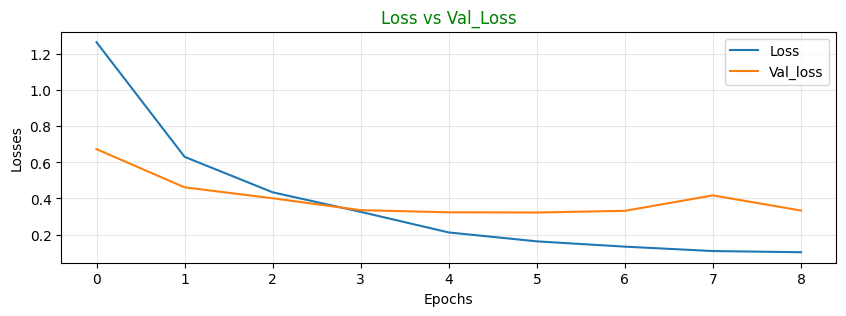

In [18]:
figsize = plt.figure(figsize=(10,3))
plt.plot(History1.history['loss'], label='Loss')
plt.plot(History1.history['val_loss'], label='Val_loss')
plt.title("Loss vs Val_Loss", color='g')
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

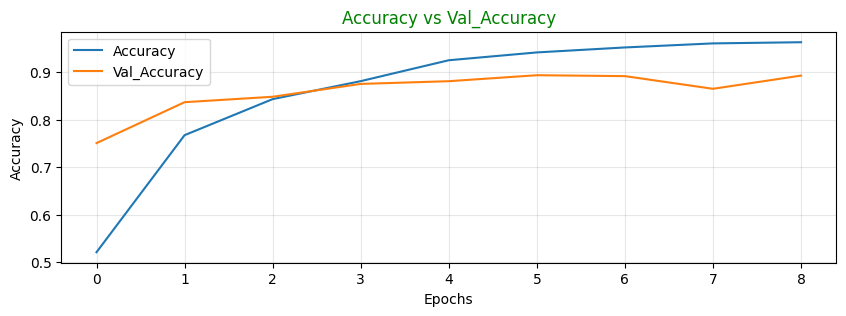

In [19]:
figsize = plt.figure(figsize=(10,3))
plt.plot(History1.history['accuracy'], label='Accuracy')
plt.plot(History1.history['val_accuracy'], label='Val_Accuracy')
plt.title("Accuracy vs Val_Accuracy", color='g')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


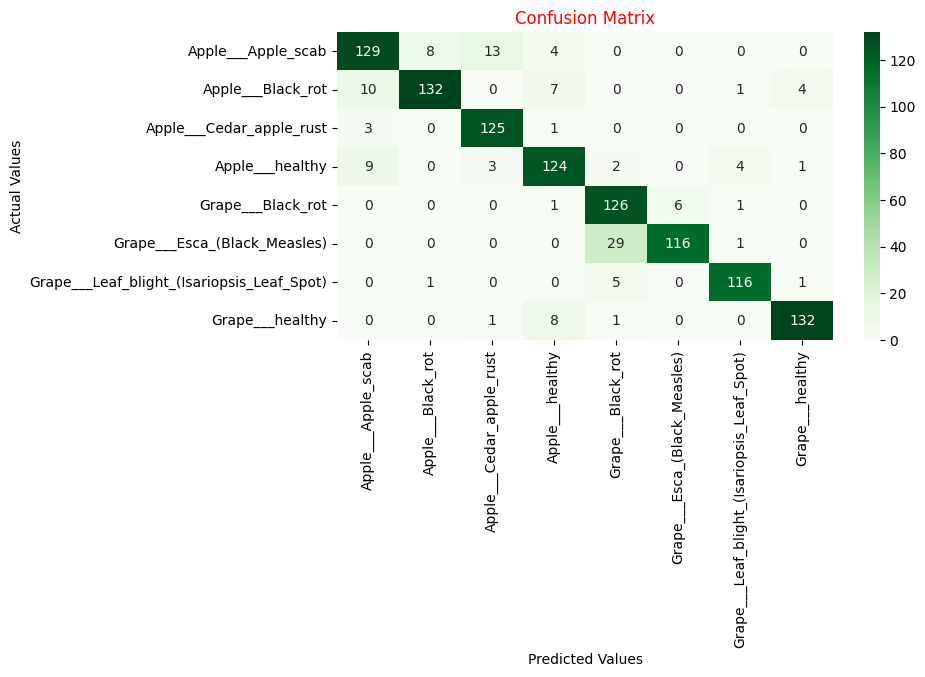

In [20]:
y_pred = model1.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix", color='r')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## Model trainning with complex CNN architecture

In [22]:
model2 = Sequential([
    Input(shape = (img_size, img_size, 1)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(label_count, activation='softmax'),
])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 175, 175, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 87, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     1,280,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,008 (10.91 MB)

 Trainable params: 2,859,008 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
History2 = model2.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks = EarlyStopping(patience=4, restore_best_weights=True, verbose=1)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.3181 - loss: 1.6766 - val_accuracy: 0.7476 - val_loss: 0.6644
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7441 - loss: 0.6634 - val_accuracy: 0.8433 - val_loss: 0.3942
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8333 - loss: 0.4494 - val_accuracy: 0.8776 - val_loss: 0.3464
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8842 - loss: 0.3204 - val_accuracy: 0.8986 - val_loss: 0.2711
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9119 - loss: 0.2475 - val_accuracy: 0.9131 - val_loss: 0.2371
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9340 - loss: 0.1865 - val_accuracy: 0.9295 - val_loss: 0.1967
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9434 - loss: 0.1598 - val_accuracy: 0.9386 - val_loss: 0.1678
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9517 - loss: 0.1360 - 

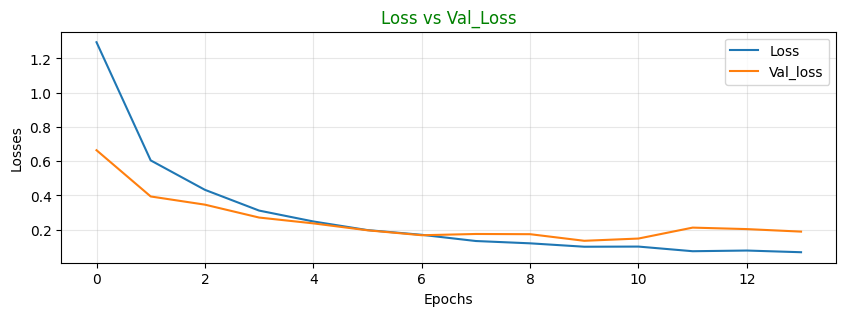

In [25]:
figsize = plt.figure(figsize=(10,3))
plt.plot(History2.history['loss'], label='Loss')
plt.plot(History2.history['val_loss'], label='Val_loss')
plt.title("Loss vs Val_Loss", color='g')
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

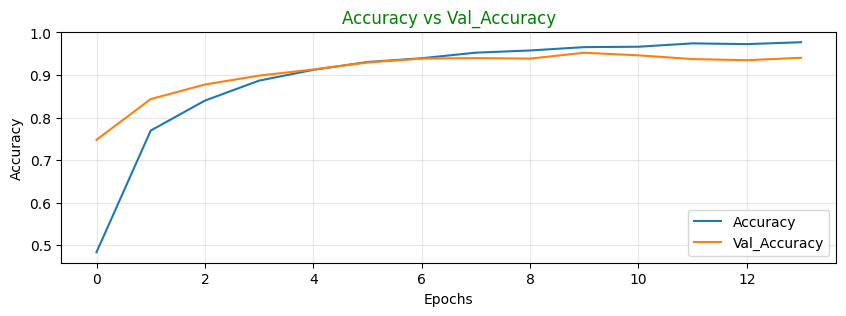

In [26]:
figsize = plt.figure(figsize=(10,3))
plt.plot(History2.history['accuracy'], label='Accuracy')
plt.plot(History2.history['val_accuracy'], label='Val_Accuracy')
plt.title("Accuracy vs Val_Accuracy", color='g')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


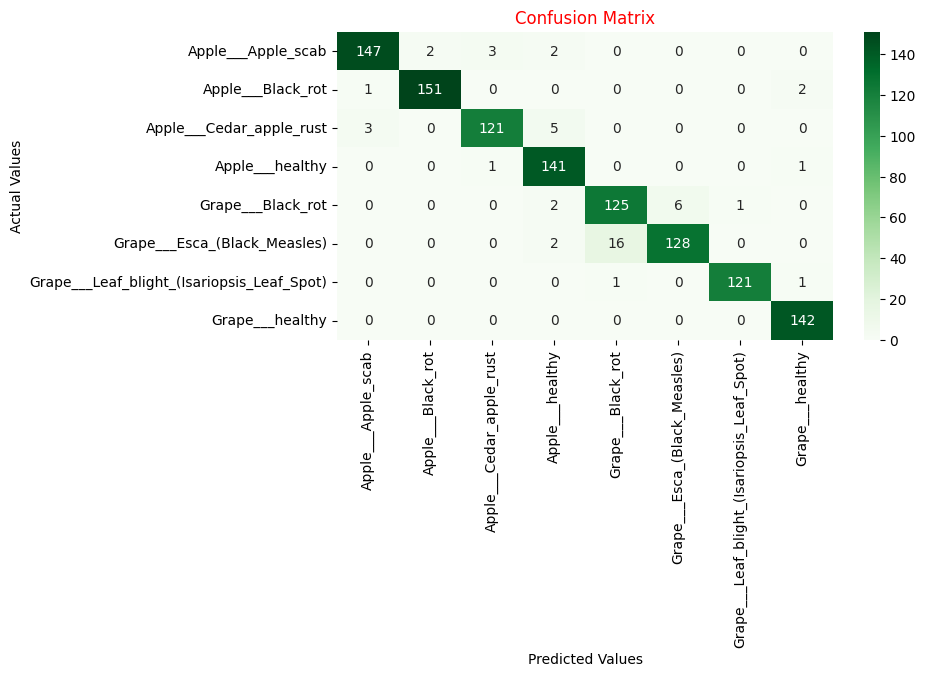

In [27]:
y_pred = model2.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix", color='r')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## Model trainning with Data Augmentation

In [29]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = datagen.flow(x_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=32)

In [40]:
model3 = Sequential([
    Input(shape = (img_size, img_size, 1)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=256, kernel_size=3, padding='valid', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(label_count, activation='softmax'),
])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 175, 175, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 87, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     1,280,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577,026 (32.72 MB)

 Trainable params: 2,859,008 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,718,018 (21.81 MB)

In [41]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
History3 = model3.fit(
    train_generator,
    epochs=20,
    validation_data = validation_generator,
    callbacks = EarlyStopping(patience=4, restore_best_weights=True, verbose=1)
)


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - accuracy: 0.3276 - loss: 1.6980 - val_accuracy: 0.5646 - val_loss: 1.1825
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.6622 - loss: 0.8626 - val_accuracy: 0.6881 - val_loss: 0.8886
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.7796 - loss: 0.5835 - val_accuracy: 0.7061 - val_loss: 0.9837
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.8337 - loss: 0.4466 - val_accuracy: 0.8372 - val_loss: 0.4400
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.8696 - loss: 0.3590 - val_accuracy: 0.8738 - val_loss: 0.3468
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.8875 - loss: 0.3023 - val_accuracy: 0.8894 - val_loss: 0.2999
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.8994 - loss: 0.2724 - val_accuracy: 0.8647 - val_loss: 0.4142
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9150 - loss: 0.2430 - 

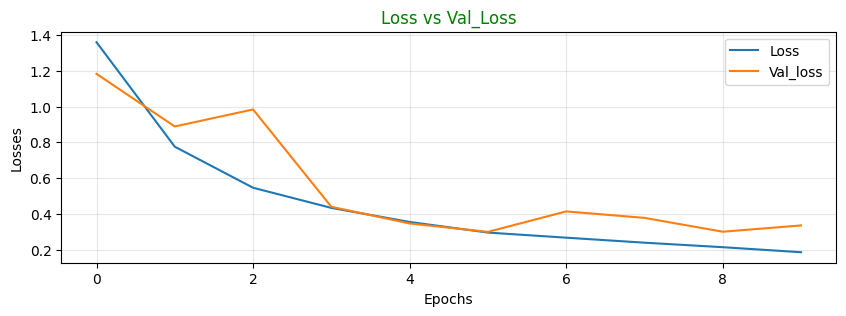

In [43]:
figsize = plt.figure(figsize=(10,3))
plt.plot(History3.history['loss'], label='Loss')
plt.plot(History3.history['val_loss'], label='Val_loss')
plt.title("Loss vs Val_Loss", color='g')
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

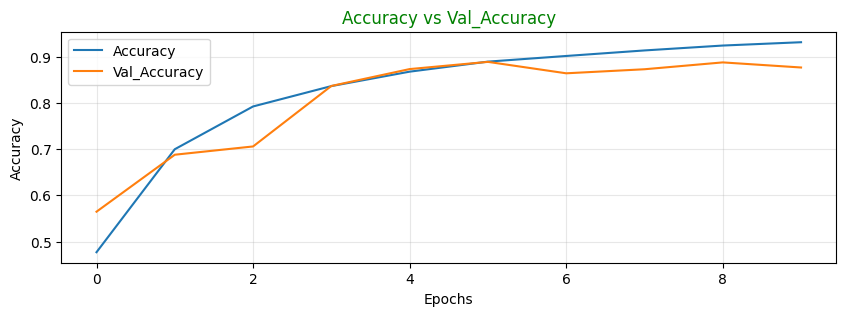

In [44]:
figsize = plt.figure(figsize=(10,3))
plt.plot(History3.history['accuracy'], label='Accuracy')
plt.plot(History3.history['val_accuracy'], label='Val_Accuracy')
plt.title("Accuracy vs Val_Accuracy", color='g')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


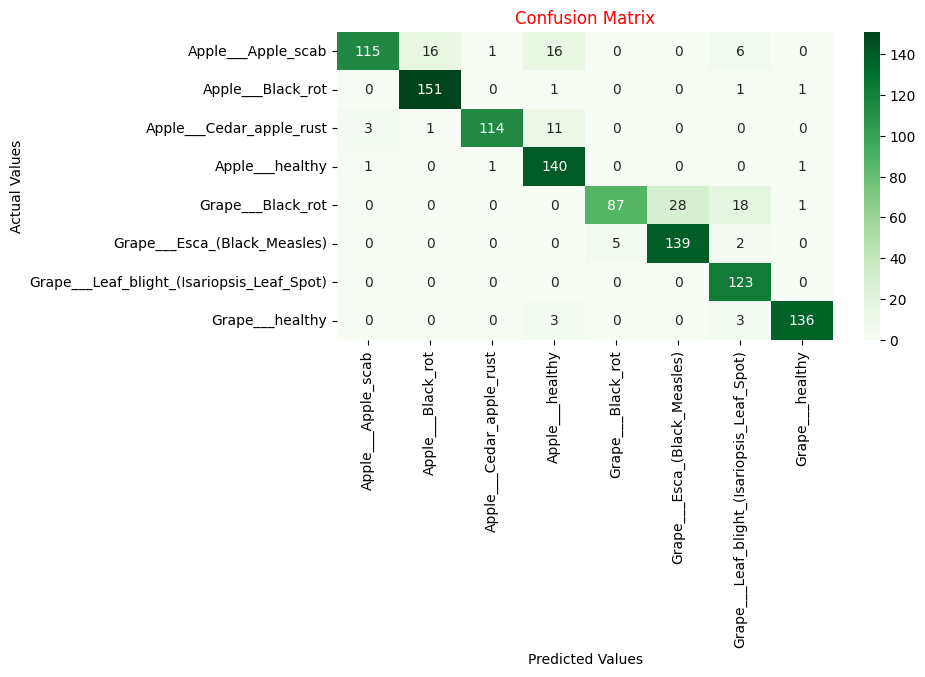

In [45]:
y_pred = model3.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix", color='r')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [46]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.75      0.84       154
           1       0.90      0.98      0.94       154
           2       0.98      0.88      0.93       129
           3       0.82      0.98      0.89       143
           4       0.95      0.65      0.77       134
           5       0.83      0.95      0.89       146
           6       0.80      1.00      0.89       123
           7       0.98      0.96      0.97       142

    accuracy                           0.89      1125
   macro avg       0.90      0.89      0.89      1125
weighted avg       0.90      0.89      0.89      1125



## Saving the best Model of our Project -- Model 2

In [47]:
class ModelWrapper():
    def __init__(self, model3, encoder):
        self.model = model3
        self.encoder = encoder

    def img_read(self, path):
        IMAGE_INPUT_SIZE = 175
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE))
        
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        img = img.reshape(1, IMAGE_INPUT_SIZE, IMAGE_INPUT_SIZE, 1)
        z = self.model.predict(img)
        index = np.argmax(z)
        
        print("Predicted accuracy(%):", z[0][index] * 100)
        predicted_label = self.encoder.inverse_transform([index])
        
        if z[0][index] * 100 >= 60:
            print("Predicted class:", predicted_label[0])
        else:
            print("Predicted class: Unknown")

In [48]:
MyModel = ModelWrapper(model2, encoder)
MyModel.optimizer = None  # For Keras
joblib.dump(MyModel, "FruitsModel.pkl",compress=('xz', 3))

['FruitsModel.pkl']

## Example

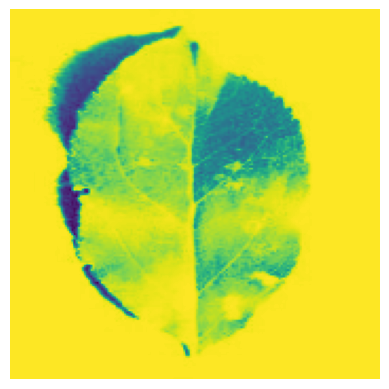

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Predicted accuracy(%): 100.0
Predicted class: Apple___Cedar_apple_rust


In [50]:
wrapper = ModelWrapper(model2, encoder)
wrapper.img_read('/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG')
